In [37]:
import random
from collections import namedtuple
from matplotlib import pyplot as plt

In [38]:
N= 200

NUM_GENERATIONS= 1000

OFFSPRING_SIZE = 20
POPULATION_SIZE= 30

MIN= -1000000000
MAX= 1000000000




In [39]:
#The function that creates randomly the lists for the Set Covering Problem

def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

lists = sorted(list(set((tuple(sorted(l))) for l in problem(N, seed= 42))),  key=lambda l: len(l))
PROBLEM_SIZE= len(lists)


# Functions for Personal Algorithm

In [40]:
def add_list(lists, state):
    for l in lists:
        for i in l:
            if not any(element == i for element in state[0]):
                state[0]= set(list(state[0]) + list(l))
                state[1]= set(list(state[1]) + [lists.index(l)])
                return 


def heuristic_mutation(lists, state, added):
    # remove the list with the maximum cost from the set of selected lists so far. The cost is calculated as the number of
    # repetitions minus the number of new elemements of the considered list, w.r.t. the selected lists so far without 
    # the considered list
    selectedLists=[]
    selectedCost=[MIN, []]
    for i in state[1]:
        selectedLists.append(lists[i])
    for l in selectedLists:
        temp= selectedLists.copy()
        temp.remove(l)
        curr=[]
        for el in temp:
            curr+= el
        curr= set(curr)
        t= list(curr) + list(l)
        repetitions= len(t) - len(set(t))
        newElements= len(set(t)) - len(curr)
        cost= repetitions - newElements
        if(cost > selectedCost[0] and l != added):
            selectedCost= [cost, l]
    rem= selectedCost[1]
    state[1].remove(lists.index(selectedCost[1]))
    selectedLists.remove(selectedCost[1])
    concatenation=[]
    for e in selectedLists:
        concatenation+= e
    state[0]= set(concatenation)

    # add the list with the minimum cost from all the lists at disposal. The cost is caculated as the number of repetitions 
    # minus the number of new elemements of the considered list, w.r.t. the selected lists so far (already without the 
    # removed list, see the code above)
    selectedCost=[MAX, []]
    for l in lists:
        temp= list(state[0]) + list(l)
        repetitions= len(temp) - len(set(temp))
        newElements= len(set(temp)) - len(state[0])
        cost= repetitions - newElements
        if (cost < selectedCost[0] and l != rem ): #and not any(lists.index(l)== e for e in state[1])):#and l != rem ):#and not any(lists.index(l)== e for e in state[1])):
            selectedCost= [cost, l]
    state[1].add(lists.index(selectedCost[1]))
    for e in selectedCost[1]:
        state[0].add(e)
        
    return selectedCost[1]
        
            
def condToExit(lists, state):
    w=0
    for i in state[1]:
        w+= len(lists[i])
    if w==N and len(state[0])==N:
        return True
    else:
        return False     


    

# Functions for GA

In [41]:
def setcovering(genome, lists):
    w=0
    for i in range(len(genome)):
        w+= genome[i]*len(lists[i])
    return w

def isASolution(ind, lists):
    l=[]
    for i in range(PROBLEM_SIZE):
        if ind.genome[i]==1:
            l+=lists[i]
    l= set(l)
    #return 0 if it is a solution, 1 if a number is missing to be a solution...
    return len(set(range(N)))-len(l)


def tournament(population, tournament_size=2):
    return min(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def cross_over_four(g1, g2):
    cut1 = random.randint(0, int(PROBLEM_SIZE/3))
    cut2 = random.randint(int(PROBLEM_SIZE/3), int(2*PROBLEM_SIZE/3))
    cut3 = random.randint(int(2*PROBLEM_SIZE/3), PROBLEM_SIZE)
    if random.random() < 0.5:
        return g1[:cut1] + g2[cut1:cut2] + g1[cut2:cut3] + g2[cut3:]
    else:
        return g2[:cut1] + g1[cut1:cut2] + g2[cut2:cut3] + g1[cut3:]
    

def cross_over(g1, g2):
    cut = random.randint(0, PROBLEM_SIZE)
    if random.random() < 0.5:
        return g1[:cut] + g2[cut:]
    else:
        return g2[:cut] + g1[cut:]


def mutation(g):
    point = random.randint(0, PROBLEM_SIZE - 1)
    return g[:point] + (1 - g[point],) + g[point + 1 :]


def sorter(ind, lists): 
    isASol= isASolution(ind, lists) 
    w= ind.fitness
    return (isASol, w)
        

# MAIN

Personal Algorithm:
Selected Lists=  [(3, 8, 9, 10, 15, 17, 26, 37, 49, 58, 63, 65, 68, 78, 83, 84, 98, 99, 101, 112, 121, 128, 131, 138, 139, 155, 159, 162, 167, 179, 182, 183, 184, 189), (2, 19, 35, 42, 43, 50, 56, 57, 65, 68, 73, 75, 78, 85, 88, 91, 94, 96, 99, 107, 109, 113, 114, 127, 128, 137, 143, 145, 146, 190, 194, 196, 197, 199), (1, 24, 26, 29, 30, 40, 46, 50, 52, 68, 78, 85, 92, 93, 99, 105, 112, 113, 119, 120, 125, 127, 130, 144, 145, 158, 160, 165, 170, 173, 174, 186, 192, 196), (0, 1, 7, 12, 15, 19, 41, 50, 59, 64, 66, 71, 74, 81, 82, 87, 92, 105, 111, 114, 115, 125, 127, 128, 129, 133, 135, 140, 143, 155, 156, 167, 170, 187, 199), (8, 14, 20, 21, 25, 47, 66, 67, 71, 75, 80, 82, 83, 92, 94, 106, 107, 111, 114, 123, 137, 138, 145, 154, 162, 170, 176, 178, 180, 184, 186, 190, 191, 192, 199), (1, 21, 25, 27, 28, 31, 35, 39, 41, 46, 50, 57, 64, 68, 76, 90, 91, 93, 95, 101, 105, 109, 110, 111, 112, 120, 124, 125, 131, 135, 137, 168, 181, 191, 196), (4, 11, 23, 30, 31, 34, 35, 

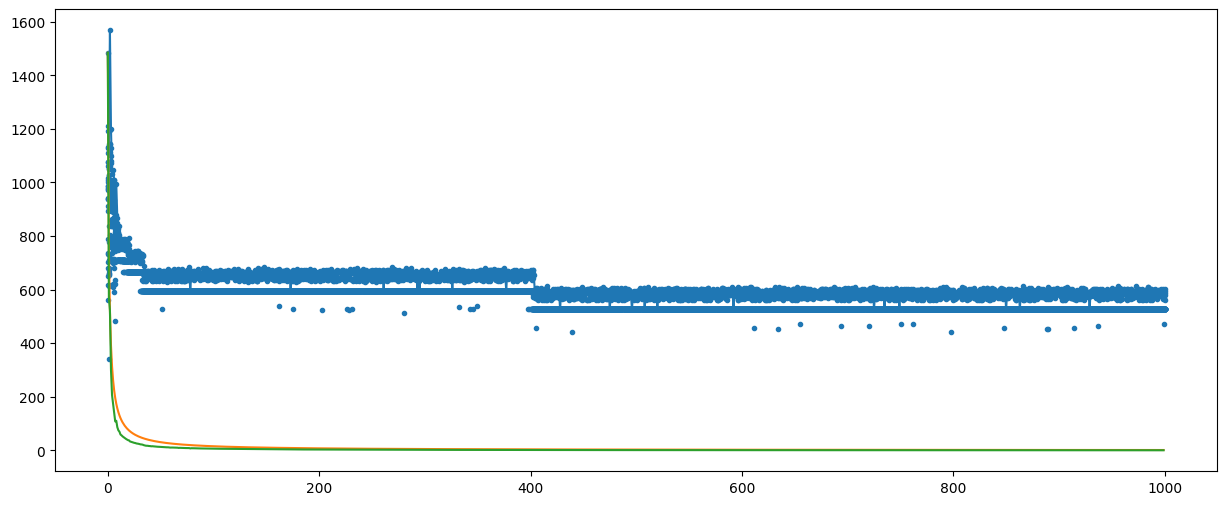

In [42]:
if __name__ == "__main__":

    #-------------------------------------------------------------------------------------------------#

    # PERSONAL ALGORITHM JOINING DIFFERENT TECHNIQUES
    #state= [{numbers obtained so far: goal 0..N-1}, {indeces of lists that composes it}]
    state= [set(), set()] 
    exit_= False
    
    while len(state[0]) < N:
        add_list(lists, state) 
        if condToExit(lists, state):
            exit_= True
            break
    added=[]
    for g in range(NUM_GENERATIONS):
        added= heuristic_mutation(lists, state, added)
        if condToExit(lists, state):
            exit_= True
            break
        
    while len(state[0]) < N:
        add_list(lists, state) 
        
    selLists=[]
    w=0
    for i in state[1]:
        selLists.append(lists[i])
        w+= len(lists[i])
    
    print("Personal Algorithm:")
    # print(len(state[0]))
    print("Selected Lists= ",selLists)
    print("Weight= ", w, "\n\n")     
    
       
    #------------------------------------------------------------------------------------------------#

    #GENETIC ALGORITHM
    population= list()
    Individual= namedtuple("Individual", ["genome", "fitness"])
    for genome in [tuple([random.choices([1, 0], weights = [1, 50], k=1)[0] for _ in range(PROBLEM_SIZE)]) for _ in range(POPULATION_SIZE)]:
        population.append(Individual(genome, setcovering(genome, lists)))
    
    
    fitness_log = [(0, i.fitness) for i in population]

    for g in range(NUM_GENERATIONS):
        offspring = list()
        for i in range(OFFSPRING_SIZE):
            r= random.random()
            if  r < 0.2:
                p = tournament(population)
                o = mutation(p.genome)
            elif r >= 0.2 and r < 0.5:
                p1 = tournament(population)
                p2 = tournament(population)
                o = cross_over_four(p1.genome, p2.genome)
            else:
                p1 = tournament(population)
                p2 = tournament(population)
                o = cross_over(p1.genome, p2.genome)

            f = setcovering(o, lists)
            fitness_log.append((g + 1, f))
            offspring.append(Individual(o, f))
        population += offspring
        
        population = sorted(population, key= lambda i: sorter(i, lists))[:POPULATION_SIZE]
    
    #print(population)
    bestSolutionReached= population[0]
    selectedLists=[]
    for i in range(PROBLEM_SIZE):
        if bestSolutionReached.genome[i]==1:
            selectedLists.append(lists[i])
    print("Genetic Agorithm:\nSelected Lists: ", selectedLists, "\nWeight= ", bestSolutionReached.fitness) 
    concatenation=[]  
    for i in selectedLists:
        concatenation+= i
    print(len(set(concatenation)))
    
    #code for plotting
    off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
    on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
    gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

    plt.figure(figsize=(15, 6))
    plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
    plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
    plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
    plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])

    #--------------------------------------------------------------------------------------------------------------------#


    